In [7]:
import numpy as np
import pyphi
import matplotlib.pyplot as plt
import itertools
import scipy.optimize as so
from numba import jit
import pyphi
import matplotlib.pyplot as plt

%matplotlib inline


plt.rc('text', usetex=True)
plt.rc('figure', figsize=(12, 8))
plt.rc('font', family='serif', serif='Computer Modern Roman', size=20)

In [20]:
@jit
def fullmodeltpm(ka, kb, kc, p1, p2):
    mat = np.zeros([2**5, 5]);
    mat[0] = [0,0,0,p1,p2]
    mat[1] = [1-ka, 0,0,p1,p2]
    mat[2] = [0,1-kb,0,p1,p2]
    mat[3] = [1-ka,1-kb,0,p1,p2]
    mat[4] = [0,0,1-kc,p1,p2]
    mat[5] = [1-ka-kc,0,1-kc,p1,p2]
    mat[6] = [0,1-kb-kc,1-kc,p1,p2]
    mat[7] = [1-ka-kc,1-kb-kc,1-ka-kb-kc,p1,p2]
    
    mat[8] = [1,0,0,p1,p2]
    mat[9] = [1-ka, 0,1,p1,p2]
    mat[10] = [1,1-kb,0,p1,p2]
    mat[11] = [1-ka,1-kb,1,p1,p2]
    mat[12] = [1,0,1-kc,p1,p2]
    mat[13] = [1-ka-kc,0,1-kc,p1,p2]
    mat[14] = [1,1-kb-kc,1-kc,p1,p2]
    mat[15] = [1-ka-kc,1-kb-kc,1-ka-kb-kc,p1,p2]
    
    mat[16] = [0,1,0,p1,p2]
    mat[17] = [1-ka, 1,0,p1,p2]
    mat[18] = [0,1-kb,1,p1,p2]
    mat[19] = [1-ka,1-kb,1,p1,p2]
    mat[20] = [0,1,1-kc,p1,p2]
    mat[21] = [1-ka-kc,1,1-kc,p1,p2]
    mat[22] = [0,1-kb-kc,1-kc,p1,p2]
    mat[23] = [1-ka-kc,1-kb-kc,1-ka-kb-kc,p1,p2]    
    
    mat[24] = [0,0,1,p1,p2]
    mat[25] = [1-ka, 0,1,p1,p2]
    mat[26] = [0,1-kb,1,p1,p2]
    mat[27] = [1-ka,1-kb,1,p1,p2]
    mat[28] = [1,1,1-kc,p1,p2]
    mat[29] = [1-ka-kc,0,1-kc,p1,p2]
    mat[30] = [0,1-kb-kc,1-kc,p1,p2]
    mat[31] = [1-ka-kc,1-kb-kc,1-ka-kb-kc,p1,p2]
    return mat



In [21]:
@jit
def modeltpm(ka, kb, kc):
    return np.array([[.25, .25, .25],[1-ka, .25, .5], [.25, 1-kb, .5],[1-ka, 1-kb, .75],[.5, .5, 1-kc],[np.max(1-ka-kc,0),.25, 1-kc],[.25, np.max(1-kb-kc,0), 1-kc],[np.max(1-ka-kc,0),np.max(1-kb-kc,0),np.max(1-ka-kb-kc,0)]])

In [22]:
@jit
def modeltpm2(ka, kb, kc, external):
    switch = {
        0: np.array([[0, 0, 0],[1-ka, 0, 0], [0, 1-kb, 0],[1-ka, 1-kb, 0],[0, 0, 1-kc],[np.max(1-ka-kc,0),0, 1-kc],[0, np.max(1-kb-kc,0), 1-kc],[np.max(1-ka-kc,0),np.max(1-kb-kc,0),np.max(1-ka-kb-kc,0)]]),
        1: np.array([[1, 0, 0],[1-ka, 0, 1], [1, 1-kb, 0],[1-ka, 1-kb, 1],[1, 0, 1-kc],[np.max(1-ka-kc,0),0, 1-kc],[1, np.max(1-kb-kc,0), 1-kc],[np.max(1-ka-kc,0),np.max(1-kb-kc,0),np.max(1-ka-kb-kc,0)]]),
        2: np.array([[0, 1, 0],[1-ka, 1, 0], [0, 1-kb, 1],[1-ka, 1-kb, 1],[0, 1, 1-kc],[np.max(1-ka-kc,0),1, 1-kc],[0, np.max(1-kb-kc,0), 1-kc],[np.max(1-ka-kc,0),np.max(1-kb-kc,0),np.max(1-ka-kb-kc,0)]]),
        3: np.array([[0, 0, 1],[1-ka, 0, 1], [0, 1-kb, 1],[1-ka, 1-kb, 1],[1, 1, 1-kc],[np.max(1-ka-kc,0),0, 1-kc],[0, np.max(1-kb-kc,0), 1-kc],[np.max(1-ka-kc,0),np.max(1-kb-kc,0),np.max(1-ka-kb-kc,0)]]),
    };
    return switch.get(external)


In [30]:

def transform_tpm(tpm):
    #this function changes a transition probability matrix from the 2^n x n format back to the 2^n x 2^n format.
    
    nrows = np.size(tpm,0);
    ncols = np.size(tpm,1);
    
    if nrows==ncols:
        print('do something');
    
    elif np.log2(nrows) == ncols:
        
        options = np.array(list(itertools.product([0,1], repeat = ncols)))
        options= np.array([i[::-1] for i in options])

        
        new = np.ones([nrows, nrows]);
        
        for i in range(nrows):
            for j in range(nrows):
                for k in range(ncols):
                    adj = (tpm[i,k] if options[j,k] else 1-tpm[i,k])
                    new[i,j] *= adj              
        
        return new

In [31]:
@jit
def stat_dist(tpm):
    eps = 1e-4;
    eig, vec = np.linalg.eig(tpm.T);
    
    eig = np.sort(eig);
    
    if eig[0]>-1+eps and eig[-2] < 1-eps:
        ans =vec.T[0];
        #if ans[0] <0:
        #    ans = np.multiply(-1, ans)
        #print(abs(ans))
        scale = np.sum(ans)
        return np.divide(ans,scale)
    else:
        print('A unique stationary distribution does not exist')
        print(eig)
        print(tpm)
    

In [32]:
@jit
def expected_waste(k1,k2,k3, c1, c2, c3, p1, p2):
    print(k1,k2,k3)
    TPM = transform_tpm(fullmodeltpm(k1,k2,k3, p1, p2));
    dist = stat_dist(TPM);
    print(dist)
    ans = 0.25*(dist[5]*(c1+c2) + dist[6]*(c2+c3) + dist[7]*(c1+c2+c3))
    print(k1,k2,k3, ' EXPECTED WASTE: ', ans)
    return ans

In [82]:
def expected_outcome(k1,k2,k3,c1,c2,c3, p1, p2):
    cm = np.zeros([5,5])
    cm[:, :3] = np.ones([5,3])
    
    waste = np.zeros(32)
    waste[13] , waste[15] = c1,c1;
    waste[22], waste[23] = c2,c2;
    waste[29], waste[30], waste[31] = c3,c3,c3;
    
    tpm = fullmodeltpm(k1,k2,k3, p1, p2)
    TPM = transform_tpm(tpm);
    
    
    if (np.sum(TPM,1)-1<1e-5).all():
        
        dist = np.real(stat_dist(TPM));

        states = np.array(list(itertools.product([0,1], repeat = 5)))

        net = pyphi.Network(TPM, cm);

        dat = np.zeros([32])

        j=0;
        for state in states:
            cmplxs = pyphi.compute.main_complex(net,state)

            phis = cmplxs.phi

            
            dat[j] = phis
            j+=1;
        
        
        
        return dist.dot(waste), dist.dot(dat)
    else:
        print('something went wrong')


In [83]:
delta = 1e-5
resources = 0.5
n = 21

c1,c2,c3 = .3, .5, .2
p1,p2 = .5,.5


def f(x, n, u, delta):
    return delta + x/(n-1)*(u-2*delta)

dat = np.zeros([n*(n+1)/2, 5])
count = 0
for i in range(n):
    for j in range(n-i):
        k1 =  i/float(n-1)*(resources )
        k2 =  j/float(n-1)*(resources )
        k3 = resources - k1-k2
        res = expected_outcome(k1,k2,k3,c1,c2,c3,p1,p2)
        dat[count] = np.array([k1,k2,k3,res[0], res[1]])
        print(dat[count])

        count+=1

        
        
#mat_list = np.array([modeltpm(i,j,resources-i-j) for j in np.linspace(0, i, resources-int(100*i)) for i in np.linspace(0,resources, 100)])

#mat_list = np.array([modeltpm(i,j,resources-i-j) for j in np.linspace(delta, i-delta, 100) for i in np.linspace(delta, resources-delta, 100)])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


[ 0.          0.          0.5         0.07627427  0.15996919]
[ 0.          0.025       0.475       0.07680749  0.14063303]
[ 0.          0.05        0.45        0.07750337  0.1398068 ]
[ 0.          0.075       0.425       0.07836907  0.14067454]
[ 0.          0.1         0.4         0.07941261  0.14323516]
[ 0.          0.125       0.375       0.08064294  0.14552282]
[ 0.          0.15        0.35        0.08207002  0.14676594]
[ 0.          0.175       0.325       0.08370484  0.15876796]
[ 0.          0.2         0.3         0.08555947  0.16984801]
[ 0.          0.225       0.275       0.08764718  0.17016764]
[ 0.          0.25        0.25        0.08998246  0.16331752]
[ 0.          0.275       0.225       0.09258103  0.15554104]
[ 0.          0.3         0.2         0.09545993  0.15357747]
[ 0.          0.325       0.175       0.09863747  0.15666484]
[ 0.          0.35        0.15        0.10213318  0.15285077]
[ 0.          0.375       0.125       0.10596763  0.14751606]
[ 0.    

[ 0.175       0.175       0.15        0.10033947  0.14550071]
[ 0.175       0.2         0.125       0.10295755  0.1404737 ]
[ 0.175       0.225       0.1         0.10586518  0.13740691]
[ 0.175       0.25        0.075       0.10907196  0.13639386]
[ 0.175       0.275       0.05        0.11258679  0.12725738]
[ 0.175       0.3         0.025       0.11641715  0.12203971]
[ 0.175       0.325       0.          0.12056818  0.10255992]
[ 0.2         0.          0.3         0.0921385   0.16984806]
[ 0.2         0.025       0.275       0.09306184  0.16449593]
[ 0.2         0.05        0.25        0.09422702  0.15374056]
[ 0.2         0.075       0.225       0.09564026  0.1432094 ]
[ 0.2         0.1         0.2         0.09730856  0.14367519]
[ 0.2         0.125       0.175       0.0992396   0.14256791]
[ 0.2         0.15        0.15        0.10144162  0.1410221 ]
[ 0.2         0.175       0.125       0.10392326  0.14156746]
[ 0.2         0.2         0.1         0.10669325  0.14141071]
[ 0.2   

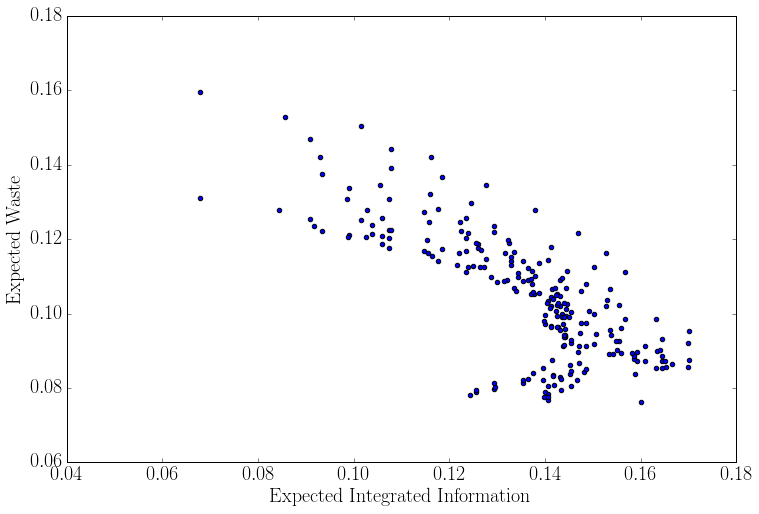

In [9]:
plt.scatter(dat1[:,4], dat1[:,3])
plt.ylabel('Expected Waste')
plt.xlabel('Expected Integrated Information')
plt.savefig('phicostplot.pdf', dpi = 900)

In [89]:
np.savetxt('simplemodeldat1.csv',dat)

In [3]:
dat1 = np.loadtxt('simplemodeldat1.csv')